# Optimization of TensorFlow models with TF-Lite

In this notebook you will learn how to use the TensorFlow integration for TF-Lite to increase inference performance.This notebook trains an Fashion-MNIST model from scratch, checks its accuracy in TensorFlow, and then converts the model into a Tensorflow Lite flatbuffer with post-training, dynamic range quantization and quantization aware training. Finally, it checks the accuracy of the converted model and compare it to the original float model.

More detail and information related to this scenarios are in: https://www.tensorflow.org/model_optimization

- [Post-training float16 quantization](https://www.tensorflow.org/lite/performance/post_training_float16_quant)
- [Post-training dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant)
- [Post-training integer quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)
- [Quantization aware training](https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html)

## Objectives

By the time you complete this workshop you will be able to:

- Describe how TF-Lite optimizes models
- Optimize Fashion MNIST deep learning model with TF-Lite
- Use TF-Lite to optimize models with Post-training float16 quantization
- Use TF-Lite to optimize models with Post-training dynamic range quantization
- Use TF-Lite to optimize models with Post-training integer quantization
- Use TF-Lite to optimize models with Quantization aware training
- Perform experiments to understand the impact of conversion parameters on optimization

## Check GPU

In [92]:
!nvidia-smi

Sat Apr 18 19:08:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.75       Driver Version: 445.75       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   50C    P0     8W /  N/A |    137MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# Describe how TF-Lite optimize models

## Imports

In [1]:
import sys
assert sys.version_info >= (3, 5)

try:
    %tensorflow_version 2.x
    !pip install -U tqdm
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tempfile
import os

from tqdm.notebook import trange
from collections import OrderedDict

np.random.seed(42)
tf.random.set_seed(42)

### Randomize Training Batch Function

In [36]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

### Plot Images Function

In [37]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Evaluate function TF-Lite Backend

In [38]:
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  prediction_digits = []
  for test_image in X_test:
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    interpreter.invoke()

    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == y_test[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [39]:
def evaluate_model_quant_aware_training(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  prediction_digits = []
  for i, test_image in enumerate(X_test):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()
  return accuracy

### Load Dataset

In [40]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Plot Dataset

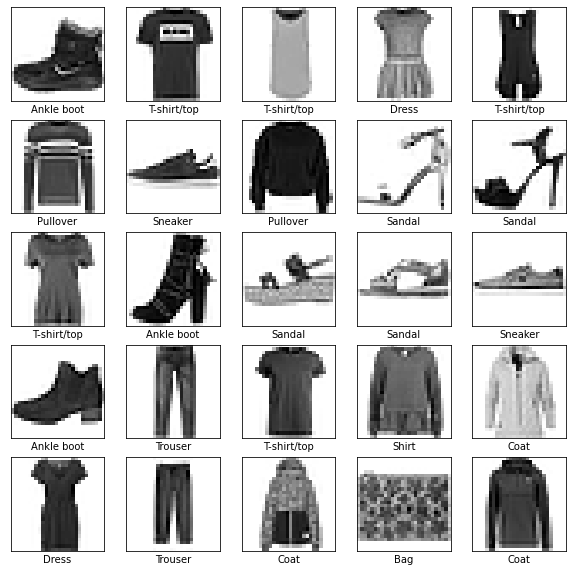

In [41]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_full[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_full[i]])
plt.show()

### Create Model

In [42]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

### Training settings

In [44]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

### Eager training

#### Computing gradients

Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks. During eager execution, use tf.GradientTape to trace operations for computing gradients later.

You can use tf.GradientTape to train and/or compute gradients in eager. It is especially useful for complicated training loops. 
Since different operations can occur during each call, all forward-pass operations get recorded to a "tape". To compute the gradient, play the tape backwards and then discard. A particular tf.GradientTape can only compute one gradient; subsequent calls throw a runtime error.

In [45]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

In [46]:
model.save('./models/fashion.h5')

In [47]:
predictions = model.predict(X_test)

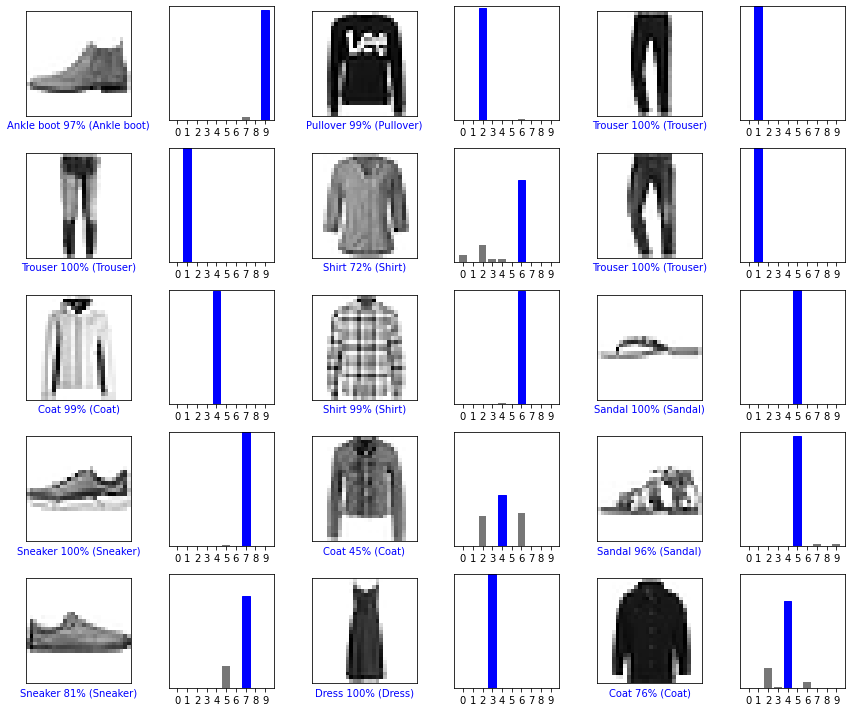

In [48]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

### Convert to a TensorFlow Lite model

Now load the model using the TFLiteConverter:

In [49]:
model = tf.keras.models.load_model('./models/fashion.h5')

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [51]:
tflite_models_dir = pathlib.Path("/tmp/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [52]:
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

319280

## Post-training float16 quantization

TensorFlow Lite now supports converting weights to 16-bit floating point values during model conversion from TensorFlow to TensorFlow Lite's flat buffer format. This results in a 2x reduction in model size. Some harware, like GPUs, can compute natively in this reduced precision arithmetic, realizing a speedup over traditional floating point execution. 

The Tensorflow Lite GPU delegate can be configured to run in this way. However, a model converted to float16 weights can still run on the CPU without additional modification: the float16 weights are upsampled to float32 prior to the first inference. This permits a significant reduction in model size in exchange for a minimal impacts to latency and accuracy.

To instead quantize the model to float16 on export, first set the optimizations flag to use default optimizations. Then specify that float16 is the supported type on the target platform:

In [53]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [54]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

160780

### Run the TensorFlow Lite models FP16

Load the model into the interpreters

In [55]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [56]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [57]:
test_image = np.expand_dims(X_test[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

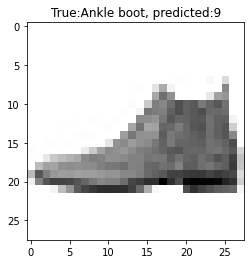

In [58]:
plt.imshow(X_test[0], cmap=plt.cm.binary)
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(class_names[y_test[0]]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [59]:
test_image = np.expand_dims(X_test[0], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)

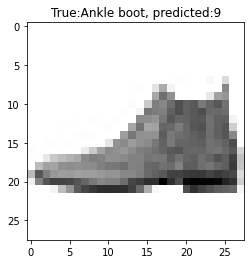

In [60]:
plt.imshow(X_test[0], cmap=plt.cm.binary)
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(class_names[y_test[0]]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [61]:
print(evaluate_model(interpreter))

0.8538


In [62]:
print(evaluate_model(interpreter_fp16))

0.8538


## Post-training dynamic range quantization

Dynamic range quantization achieves a 4x reduction in the model size. In addition, TFLite supports on the fly quantization and dequantization of activations to allow for:

 - Using quantized kernels for faster implementation when available.
 - Mixing of floating-point kernels with quantized kernels for different parts of the graph.
 
The activations are always stored in floating point. For ops that support quantized kernels, the activations are quantized to 8 bits of precision dynamically prior to processing and are de-quantized to float precision after processing. Depending on the model being converted, this can give a speedup over pure floating point computation.

In contrast to quantization aware training , the weights are quantized post training and the activations are quantized dynamically at inference in this method. Therefore, the model weights are not retrained to compensate for quantization induced errors. It is important to check the accuracy of the quantized model to ensure that the degradation is acceptable.

In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [64]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dynamic_quant_model = converter.convert()
tflite_model_dynamic_quant_file = tflite_models_dir/"model_dynamic_quant.tflite"
tflite_model_dynamic_quant_file.write_bytes(tflite_dynamic_quant_model)

84136

### Run the TensorFlow Lite models Post Training Dynamic Range

In [65]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [66]:
interpreter_dynamic_quant = tf.lite.Interpreter(model_path=str(tflite_model_dynamic_quant_file))
interpreter_dynamic_quant.allocate_tensors()

In [67]:
test_image = np.expand_dims(X_test[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

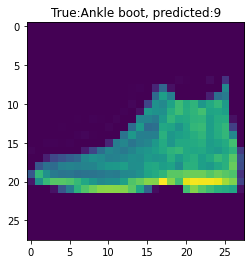

In [68]:
import matplotlib.pylab as plt

plt.imshow(X_test[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(class_names[y_test[0]]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [69]:
print(evaluate_model(interpreter))

0.8538


In [70]:
print(evaluate_model(interpreter_dynamic_quant))

0.854


## Post-training integer quantization

TensorFlow Lite now supports converting all model values (weights and activations) to 8-bit integers when converting from TensorFlow to TensorFlow Lite's flat buffer format. This results in a 4x reduction in model size and a 3 to 4x performance improvement on CPU performance. In addition, this fully quantized model can be consumed by integer-only hardware accelerators.
In contrast to post-training "on-the-fly" quantization which stores only the weights as 8-bit integers this technique statically quantizes all weights and activations during model conversion.

In [71]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [72]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

In [73]:
mnist_train, _ = keras.datasets.fashion_mnist.load_data()
images = tf.cast(mnist_train[0], tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    yield [input_value]

converter.representative_dataset = representative_data_gen

In [74]:
tflite_model_post_training_quant = converter.convert()
tflite_model_post_training_quant_file = tflite_models_dir/"model_post_training_quant.tflite"
tflite_model_post_training_quant_file.write_bytes(tflite_model_post_training_quant)

81712

Your model should now be fully quantized. However, if you convert a model that includes any operations that TensorFlow Lite cannot quantize, those ops are left in floating point. This allows for conversion to complete so you have a smaller and more efficient model, but the model won't be compatible with some ML accelerators that require full integer quantization. Also, by default, the converted model still use float input and outputs, which also is not compatible with some accelerators.
So to ensure that the converted model is fully quantized (make the converter throw an error if it encounters an operation it cannot quantize), and to use integers for the model's input and output, you need to convert the model again using these additional configurations:

In [75]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_io_quant = converter.convert()
tflite_model_io_quant_file = tflite_models_dir/"model_quant_int8.tflite"
tflite_model_io_quant_file.write_bytes(tflite_model_io_quant)

81712

In this example, the resulting model size remains the same because all operations successfully quantized to begin with. However, this new model now uses quantized input and output, making it compatible with more accelerators, such as the Coral Edge TPU.
In the following sections, notice that we are now handling two TensorFlow Lite models: tflite_model_file is the converted model that still uses floating-point parameters, and tflite_model_quant_file is the same model converted with full integer quantization, including uint8 input and output.

### Run the TensorFlow Lite models Post-Training Integer

In [76]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [77]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_io_quant_file))
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

In [78]:
print(evaluate_model(interpreter))

0.8538


In [79]:
print(evaluate_model(interpreter_quant))

0.8536


## Quantization aware training

Quantization aware training emulates inference-time quantization, creating a model that downstream tools will use to produce actually quantized models. The quantized models use lower-precision (e.g. 8-bit instead of 32-bit float), leading to benefits during deployment.

Quantization brings improvements via model compression and latency reduction. With the API defaults, the model size shrinks by 4x, and we typically see between 1.5 - 4x improvements in CPU latency in the tested backends. Eventually, latency improvements can be seen on compatible machine learning accelerators, such as the EdgeTPU and NNAPI.
The technique is used in production in speech, vision, text, and translate use cases. 

## Clone and fine-tune trained model with quantization aware training

### Define the model
You will apply quantization aware training to the whole model and see this in the model summary. All layers are now prefixed by "quant".
Note that the resulting model is quantization aware but not quantized (e.g. the weights are float32 instead of int8). The sections after show how to create a quantized model from the quantization aware one.
In the comprehensive guide, you can see how to quantize some layers for model accuracy improvements.

In [80]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

In [81]:
q_aware_model = quantize_model(model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

In [82]:
q_aware_model.compile(optimizer='Nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer='Nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [83]:
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_flatten (QuantizeWrapp (None, 784)               1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 100)               78505     
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 10)                1015      
Total params: 79,521
Trainable params: 79,510
Non-trainable params: 11
_________________________________________________________________


In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [85]:
train_images_subset = X_train
train_labels_subset = y_train

q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=32, epochs=5, validation_split=0.1)

Train on 49500 samples, validate on 5500 samples
Epoch 1/5
49500/49500 [==============================] - 5s 109us/sample - loss: 0.3177 - accuracy: 0.8854 - val_loss: 0.3016 - val_accuracy: 0.8904
Epoch 2/5
49500/49500 [==============================] - 5s 98us/sample - loss: 0.2948 - accuracy: 0.8920 - val_loss: 0.3001 - val_accuracy: 0.8887
Epoch 3/5
49500/49500 [==============================] - 5s 102us/sample - loss: 0.2891 - accuracy: 0.8929 - val_loss: 0.2970 - val_accuracy: 0.8916
Epoch 4/5
49500/49500 [==============================] - 5s 103us/sample - loss: 0.2845 - accuracy: 0.8945 - val_loss: 0.3143 - val_accuracy: 0.8893
Epoch 5/5
49500/49500 [==============================] - 5s 98us/sample - loss: 0.2779 - accuracy: 0.8970 - val_loss: 0.2957 - val_accuracy: 0.8933


In [86]:
_, baseline_model_accuracy = model.evaluate(
    X_test, y_test, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   X_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.8538
Quant test accuracy: 0.8742


## Create quantized model for TFLite backend

In [87]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

## See persistence of accuracy from TF to TFLite

In [88]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model_quant_aware_training(interpreter)

print('Quant TFLite accuracy:', test_accuracy)
print('Quant TF accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TFLite accuracy: 0.8737
Quant TF accuracy: 0.8742


### See 4x smaller model from quantization

In [89]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

Float model in Mb: 0.3044891357421875
Quantized model in Mb: 0.080780029296875


In this notebook, you saw how to create quantization aware models with the TensorFlow Model Optimization Toolkit API and then quantized models for the TFLite backend.
You saw a 4x model size compression benefit for a model for Fashion-MNIST, with minimal accuracy difference.